# CNN with CIFAR-10
Training several convolutional neural networks to classify CIFAR-10 images. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
import random
import torch
from torch import nn, optim
import math
from IPython import display
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import pdb

#### Setting a Seed for Random Number Generators in Python and PyTorch

In [2]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

#### Import dataset


In [3]:
from torch.utils.data import random_split
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# determine size of validation and training datasets
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# split dataset into training and validation 
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [01:35<00:00, 1792703.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Building Data Loaders

In [4]:

from torch.utils.data import DataLoader
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# assert the size of the train dataset
assert len(train_dataset) == 45000
assert train_dataset[0][0].shape == torch.Size([3, 32, 32])

# assert the size of the validation dataset
assert len(val_dataset) == 5000
assert val_dataset[0][0].shape == torch.Size([3, 32, 32])

# assert the size of the test dataset
assert len(test_dataset) == 10000
assert test_dataset[0][0].shape == torch.Size([3, 32, 32])

**Visulize one image from CIFAR**

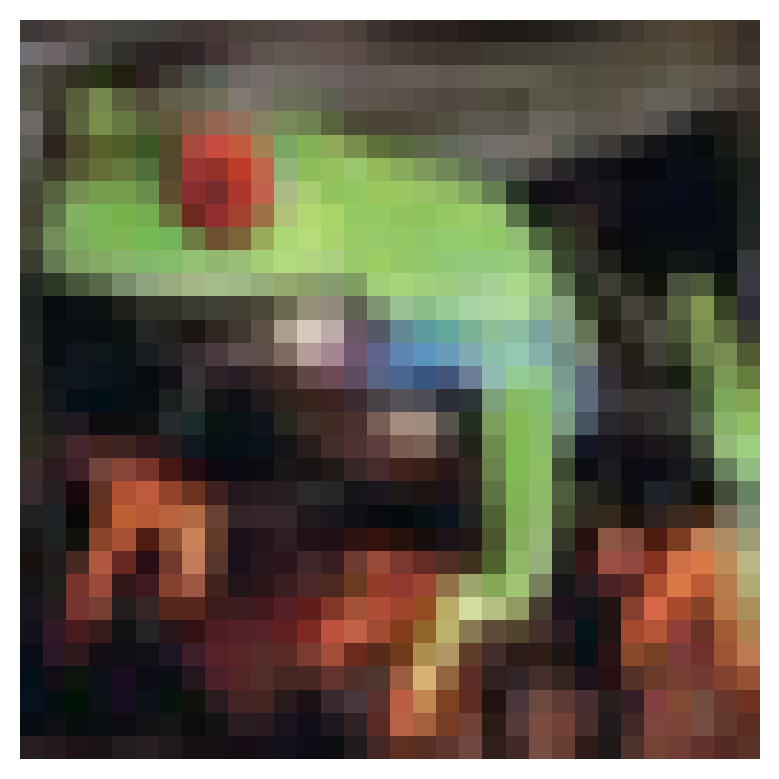

In [5]:
image, _ = trainloader.dataset.__getitem__(0)
image = image.permute(1,2,0)
plt.imshow(image, cmap=plt.cm.binary)
plt.axis('off');

#### Building a neural network.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:

import torch.nn.functional as F
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 1024)  
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


model = Model_3()
print(model)


Model_3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


#### Step-4: Training the model

In [10]:
def evaluate_model(model, dataloader, is_test=False):
  #Evaluation

  # Set model to evaluation mode
  model.eval()

  with torch.no_grad():
    correct = 0
    loss = 0

    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        loss += torch.sum(criterion(outputs, target)).item()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    loss /= len(dataloader.dataset)
    accuracy = 100. * correct / len(dataloader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        "Test" if is_test else "Validation",
        loss, correct, len(dataloader.dataset),
        accuracy))
  # Set model back to training mode
  model.train()

def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_accuracy = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_accuracy += predicted.eq(target).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * train_accuracy / len(train_loader.dataset)
        
        print('Train Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.0f}%'.format(
            epoch+1, num_epochs, train_loss, train_accuracy))
        
        evaluate_model(model, valid_loader)


# set hyperparameters
learning_rate = 0.01
num_epochs = 10
model = Model_3().to(device)

#define arguments
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train model
train_model(model, trainloader, val_loader, optimizer, criterion, num_epochs)

Train Epoch [1/10], Train Loss: 0.0179, Train Acc: 12%

Validation set: Average loss: 2.2702, Accuracy: 914/5000 (18%)

Train Epoch [2/10], Train Loss: 0.0171, Train Acc: 23%

Validation set: Average loss: 2.0955, Accuracy: 1259/5000 (25%)

Train Epoch [3/10], Train Loss: 0.0157, Train Acc: 28%

Validation set: Average loss: 2.0027, Accuracy: 1348/5000 (27%)

Train Epoch [4/10], Train Loss: 0.0153, Train Acc: 30%

Validation set: Average loss: 1.9307, Accuracy: 1497/5000 (30%)

Train Epoch [5/10], Train Loss: 0.0148, Train Acc: 33%

Validation set: Average loss: 1.8662, Accuracy: 1720/5000 (34%)

Train Epoch [6/10], Train Loss: 0.0142, Train Acc: 36%

Validation set: Average loss: 1.7998, Accuracy: 1744/5000 (35%)

Train Epoch [7/10], Train Loss: 0.0137, Train Acc: 38%

Validation set: Average loss: 1.7284, Accuracy: 1859/5000 (37%)

Train Epoch [8/10], Train Loss: 0.0131, Train Acc: 40%

Validation set: Average loss: 1.6475, Accuracy: 2066/5000 (41%)

Train Epoch [9/10], Train Loss: 0

**Set hyper-parameters**

In [11]:
learning_rate = 0.01
epochs = 10
batch_size = 128

In [12]:
model_step_3 = Model_3()
model_step_3.to(device)


optimizer = torch.optim.SGD(model_step_3.parameters(), lr=learning_rate)
train_model(model_step_3, trainloader, val_loader, optimizer, criterion, epochs)

Train Epoch [1/10], Train Loss: 0.0179, Train Acc: 17%

Validation set: Average loss: 2.2720, Accuracy: 1113/5000 (22%)

Train Epoch [2/10], Train Loss: 0.0172, Train Acc: 23%

Validation set: Average loss: 2.0763, Accuracy: 1309/5000 (26%)

Train Epoch [3/10], Train Loss: 0.0157, Train Acc: 27%

Validation set: Average loss: 1.9776, Accuracy: 1478/5000 (30%)

Train Epoch [4/10], Train Loss: 0.0152, Train Acc: 30%

Validation set: Average loss: 1.9451, Accuracy: 1521/5000 (30%)

Train Epoch [5/10], Train Loss: 0.0147, Train Acc: 33%

Validation set: Average loss: 1.8494, Accuracy: 1752/5000 (35%)

Train Epoch [6/10], Train Loss: 0.0141, Train Acc: 36%

Validation set: Average loss: 1.7980, Accuracy: 1747/5000 (35%)

Train Epoch [7/10], Train Loss: 0.0135, Train Acc: 39%

Validation set: Average loss: 1.6816, Accuracy: 1989/5000 (40%)

Train Epoch [8/10], Train Loss: 0.0130, Train Acc: 41%

Validation set: Average loss: 1.6195, Accuracy: 2131/5000 (43%)

Train Epoch [9/10], Train Loss: 

In [13]:
# Evaluation
evaluate_model(model_step_3, testloader, is_test=True)


Test set: Average loss: 1.5696, Accuracy: 4382/10000 (44%)



####  Regularization

In [14]:

class Model_5(nn.Module):
    def __init__(self):
        super(Model_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 14 * 14, 1024)
        self.dropout = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)  
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x


model_step_5 = Model_5()
model_step_5.to(device)
optimizer = torch.optim.SGD(model_step_5.parameters(), lr=learning_rate, momentum=0.9)  
criterion = nn.CrossEntropyLoss()
num_epochs = 10
train_model(model_step_5, trainloader, val_loader, optimizer, criterion, num_epochs)



Train Epoch [1/10], Train Loss: 0.0151, Train Acc: 30%

Validation set: Average loss: 1.6788, Accuracy: 2020/5000 (40%)

Train Epoch [2/10], Train Loss: 0.0124, Train Acc: 43%

Validation set: Average loss: 1.4486, Accuracy: 2426/5000 (49%)

Train Epoch [3/10], Train Loss: 0.0111, Train Acc: 49%

Validation set: Average loss: 1.3261, Accuracy: 2577/5000 (52%)

Train Epoch [4/10], Train Loss: 0.0103, Train Acc: 53%

Validation set: Average loss: 1.2548, Accuracy: 2744/5000 (55%)

Train Epoch [5/10], Train Loss: 0.0096, Train Acc: 56%

Validation set: Average loss: 1.1973, Accuracy: 2887/5000 (58%)

Train Epoch [6/10], Train Loss: 0.0088, Train Acc: 60%

Validation set: Average loss: 1.1416, Accuracy: 2995/5000 (60%)

Train Epoch [7/10], Train Loss: 0.0082, Train Acc: 63%

Validation set: Average loss: 1.1012, Accuracy: 3039/5000 (61%)

Train Epoch [8/10], Train Loss: 0.0075, Train Acc: 66%

Validation set: Average loss: 1.0434, Accuracy: 3118/5000 (62%)

Train Epoch [9/10], Train Loss: 

In [15]:
# Evaluation
evaluate_model(model_step_5, testloader, is_test=True)


Test set: Average loss: 0.9941, Accuracy: 6512/10000 (65%)



#### Deeper neural network

In [16]:

import torch.nn.functional as F

class Model_6(nn.Module):
    def __init__(self):
        super(Model_6, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_step_6 = Model_6()
model_step_6.to(device)

optimizer = torch.optim.SGD(model_step_6.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_model(model_step_6, trainloader, val_loader, optimizer, criterion, num_epochs)

Train Epoch [1/10], Train Loss: 0.0170, Train Acc: 19%

Validation set: Average loss: 1.9777, Accuracy: 1405/5000 (28%)

Train Epoch [2/10], Train Loss: 0.0144, Train Acc: 33%

Validation set: Average loss: 1.6641, Accuracy: 1893/5000 (38%)

Train Epoch [3/10], Train Loss: 0.0120, Train Acc: 44%

Validation set: Average loss: 1.4064, Accuracy: 2444/5000 (49%)

Train Epoch [4/10], Train Loss: 0.0106, Train Acc: 51%

Validation set: Average loss: 1.2802, Accuracy: 2726/5000 (55%)

Train Epoch [5/10], Train Loss: 0.0095, Train Acc: 57%

Validation set: Average loss: 1.1799, Accuracy: 2899/5000 (58%)

Train Epoch [6/10], Train Loss: 0.0086, Train Acc: 61%

Validation set: Average loss: 1.0331, Accuracy: 3202/5000 (64%)

Train Epoch [7/10], Train Loss: 0.0077, Train Acc: 65%

Validation set: Average loss: 0.9599, Accuracy: 3301/5000 (66%)

Train Epoch [8/10], Train Loss: 0.0070, Train Acc: 69%

Validation set: Average loss: 0.8727, Accuracy: 3476/5000 (70%)

Train Epoch [9/10], Train Loss: 

In [17]:
# Evaluation
evaluate_model(model_step_6, testloader, is_test=True)


Test set: Average loss: 0.7970, Accuracy: 7198/10000 (72%)



#### Trying another activation function

In [18]:

class Model_7(nn.Module):
    def __init__(self):
        super(Model_7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool1(x)
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model_step_7 = Model_7()
model_step_7.to(device)

optimizer = torch.optim.SGD(model_step_7.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

train_model(model_step_7, trainloader, val_loader, optimizer, criterion, num_epochs)


Train Epoch [1/10], Train Loss: 0.0150, Train Acc: 30%

Validation set: Average loss: 1.6124, Accuracy: 2047/5000 (41%)

Train Epoch [2/10], Train Loss: 0.0112, Train Acc: 48%

Validation set: Average loss: 1.3122, Accuracy: 2698/5000 (54%)

Train Epoch [3/10], Train Loss: 0.0096, Train Acc: 56%

Validation set: Average loss: 1.1681, Accuracy: 2944/5000 (59%)

Train Epoch [4/10], Train Loss: 0.0085, Train Acc: 62%

Validation set: Average loss: 1.0497, Accuracy: 3117/5000 (62%)

Train Epoch [5/10], Train Loss: 0.0078, Train Acc: 65%

Validation set: Average loss: 0.9660, Accuracy: 3274/5000 (65%)

Train Epoch [6/10], Train Loss: 0.0071, Train Acc: 68%

Validation set: Average loss: 0.8795, Accuracy: 3491/5000 (70%)

Train Epoch [7/10], Train Loss: 0.0065, Train Acc: 71%

Validation set: Average loss: 0.8293, Accuracy: 3577/5000 (72%)

Train Epoch [8/10], Train Loss: 0.0060, Train Acc: 73%

Validation set: Average loss: 0.8362, Accuracy: 3546/5000 (71%)

Train Epoch [9/10], Train Loss: 

In [20]:
# Evaluation
evaluate_model(model_step_7, testloader, is_test=True)


Test set: Average loss: 0.7831, Accuracy: 7377/10000 (74%)

